## 1. Setup and Configuration

In [1]:
# Import required libraries
import os
import sys
import yaml
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, precision_score,
    recall_score, f1_score, confusion_matrix,
    roc_curve, auc
)
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Set up project paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(project_root, 'src'))
print(f"Project root: {project_root}")

# Load configuration
config_path = os.path.join(project_root, 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

RANDOM_STATE = config['GENERAL'].get('RANDOM_STATE', 42)
TARGET_COL = config['GENERAL'].get('TARGET_COLUMN', 'churn_label')
OUTPUTS_DIR = os.path.join(project_root, 'outputs', 'ensemble')
os.makedirs(OUTPUTS_DIR, exist_ok=True)

print(f"Random state: {RANDOM_STATE}")
print(f"Ensemble outputs dir: {OUTPUTS_DIR}")

Project root: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction
Random state: 42
Ensemble outputs dir: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble


## 2. Load Preprocessed Data from Checkpoint

Load the train/val/test splits and preprocessed features that were created in the main training notebook. This ensures consistency and saves processing time.

In [2]:
# Load checkpoint data (already split and feature-engineered)
checkpoint_path = os.path.join(project_root, config['PATHS'].get('CHECKPOINT_DATA', 'data/processed_data_split.pkl'))

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(
        f"Checkpoint file not found: {checkpoint_path}\n"
        "Please run 'churn_model_training.ipynb' first to generate the checkpoint."
    )

data_splits = pd.read_pickle(checkpoint_path)
train_df = data_splits['train']
val_df = data_splits['val']
test_df = data_splits['test']

print("Loaded data splits:")
print(f"  Train: {train_df.shape}")
print(f"  Val:   {val_df.shape}")
print(f"  Test:  {test_df.shape}")
print(f"\nChurn distribution (train): {train_df[TARGET_COL].value_counts(normalize=True).to_dict()}")

Loaded data splits:
  Train: (35000, 32)
  Val:   (7500, 32)
  Test:  (7500, 32)

Churn distribution (train): {0: 0.75, 1: 0.25}


## 3. Feature Engineering and Preprocessing

Apply the same feature engineering and preprocessing pipeline used in the baseline training.

In [3]:
# Import custom modules
try:
    from features import create_all_features
    from preprocessing import create_preprocessor
    print("Successfully imported custom modules")
except ImportError as e:
    print(f"Warning: Could not import custom modules: {e}")
    print("Using fallback implementations...")
    
    def create_all_features(df):
        return df.copy()
    
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.impute import SimpleImputer
    
    def create_preprocessor(num_feats, cat_feats):
        num_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
        return ColumnTransformer([
            ('num', num_pipe, num_feats),
            ('cat', cat_pipe, cat_feats),
        ], sparse_threshold=0)

Successfully imported custom modules


In [4]:
# Apply feature engineering
print("Applying feature engineering...")
train_fe = create_all_features(train_df)
val_fe = create_all_features(val_df)
test_fe = create_all_features(test_df)

# Separate features and target
X_train = train_fe.drop(columns=[TARGET_COL])
y_train = train_fe[TARGET_COL].astype(int)

X_val = val_fe.drop(columns=[TARGET_COL])
y_val = val_fe[TARGET_COL].astype(int)

X_test = test_fe.drop(columns=[TARGET_COL])
y_test = test_fe[TARGET_COL].astype(int)

print(f"After feature engineering: {X_train.shape[1]} features")

2025-11-18 00:13:15,777 - features - INFO - Starting feature engineering pipeline...
2025-11-18 00:13:15,781 - features - INFO - Creating tenure features...
2025-11-18 00:13:15,785 - features - INFO - Tenure features created successfully
2025-11-18 00:13:15,785 - features - INFO - Creating intensity ratio features...
2025-11-18 00:13:15,781 - features - INFO - Creating tenure features...
2025-11-18 00:13:15,785 - features - INFO - Tenure features created successfully
2025-11-18 00:13:15,785 - features - INFO - Creating intensity ratio features...
2025-11-18 00:13:15,790 - features - INFO - Intensity ratio features created successfully
2025-11-18 00:13:15,791 - features - INFO - Creating interaction features...
2025-11-18 00:13:15,793 - features - INFO - Interaction features created successfully
2025-11-18 00:13:15,790 - features - INFO - Intensity ratio features created successfully
2025-11-18 00:13:15,791 - features - INFO - Creating interaction features...
2025-11-18 00:13:15,793 - f

Applying feature engineering...
After feature engineering: 37 features
After feature engineering: 37 features


In [5]:
# Identify numerical and categorical features
num_feats = config['FEATURE_ENGINEERING'].get('NUMERICAL_FEATURES', [])
cat_feats = config['FEATURE_ENGINEERING'].get('CATEGORICAL_FEATURES', [])

if not num_feats and not cat_feats:
    num_feats = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Feature breakdown: {len(num_feats)} numerical, {len(cat_feats)} categorical")

# Create and fit preprocessor
print("\nFitting preprocessor on training data only...")
preprocessor = create_preprocessor(num_feats, cat_feats)
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print(f"Preprocessed shape: {X_train_prep.shape}")
print("Preprocessing complete!")

2025-11-18 00:13:15,883 - preprocessing - INFO - Creating preprocessor with 27 numerical and 4 categorical features
2025-11-18 00:13:15,890 - preprocessing - INFO - Sparse output: False
2025-11-18 00:13:15,891 - preprocessing - INFO - Preprocessor created successfully
2025-11-18 00:13:15,890 - preprocessing - INFO - Sparse output: False
2025-11-18 00:13:15,891 - preprocessing - INFO - Preprocessor created successfully


Feature breakdown: 27 numerical, 4 categorical

Fitting preprocessor on training data only...
Preprocessed shape: (35000, 55)
Preprocessing complete!
Preprocessed shape: (35000, 55)
Preprocessing complete!


## 4. Define Base Models for Stacking

Configure diverse base models with parameters optimized for churn prediction. Each model brings different strengths:
- **Random Forest:** Robust to outliers, handles non-linearity well
- **XGBoost:** Strong performance on structured data, handles imbalance
- **LightGBM:** Fast training, efficient memory usage
- **Logistic Regression:** Linear baseline, interpretable

In [6]:
# Base models (Level 0)
print("Configuring base models for stacking...\n")

base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    
    ('xgb', xgb.XGBClassifier(
        n_estimators=500,
        max_depth=7,
        learning_rate=0.05,
        scale_pos_weight=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )),
    
    ('lgbm', lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=7,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )),
    
    ('lr', LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
]

print("Base models configured:")
for name, model in base_models:
    print(f"  - {name.upper()}: {model.__class__.__name__}")

# Meta-learner (Level 1)
meta_learner = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print(f"\nMeta-learner: {meta_learner.__class__.__name__}")
print("  → Will learn optimal combination of base model predictions")

Configuring base models for stacking...

Base models configured:
  - RF: RandomForestClassifier
  - XGB: XGBClassifier
  - LGBM: LGBMClassifier
  - LR: LogisticRegression

Meta-learner: LogisticRegression
  → Will learn optimal combination of base model predictions


## 5. Train Individual Base Models

First, train each base model individually to evaluate their standalone performance before stacking.

In [7]:
print("Training individual base models...\n")

base_results = {}

for name, model in base_models:
    print(f"Training {name.upper()}...")
    
    # Train on training set
    model.fit(X_train_prep, y_train)
    
    # Predict on validation set
    val_proba = model.predict_proba(X_val_prep)[:, 1]
    val_roc = roc_auc_score(y_val, val_proba)
    val_pr = average_precision_score(y_val, val_proba)
    
    base_results[name] = {
        'model': model,
        'val_roc_auc': val_roc,
        'val_pr_auc': val_pr,
        'val_proba': val_proba
    }
    
    print(f"  ✓ ROC-AUC: {val_roc:.4f} | PR-AUC: {val_pr:.4f}\n")

print("="*60)
print("Base Model Performance Summary (Validation Set):")
print("="*60)
for name, results in base_results.items():
    print(f"{name.upper():6s} - ROC-AUC: {results['val_roc_auc']:.4f} | PR-AUC: {results['val_pr_auc']:.4f}")

best_base = max(base_results.items(), key=lambda x: x[1]['val_roc_auc'])
print(f"\n→ Best individual model: {best_base[0].upper()} ({best_base[1]['val_roc_auc']:.4f})")

Training individual base models...

Training RF...
  ✓ ROC-AUC: 0.9709 | PR-AUC: 0.9232

Training XGB...
  ✓ ROC-AUC: 0.9709 | PR-AUC: 0.9232

Training XGB...
  ✓ ROC-AUC: 0.9840 | PR-AUC: 0.9568

Training LGBM...
  ✓ ROC-AUC: 0.9840 | PR-AUC: 0.9568

Training LGBM...
  ✓ ROC-AUC: 0.9848 | PR-AUC: 0.9591

Training LR...
  ✓ ROC-AUC: 0.9848 | PR-AUC: 0.9591

Training LR...
  ✓ ROC-AUC: 0.9871 | PR-AUC: 0.9654

Base Model Performance Summary (Validation Set):
RF     - ROC-AUC: 0.9709 | PR-AUC: 0.9232
XGB    - ROC-AUC: 0.9840 | PR-AUC: 0.9568
LGBM   - ROC-AUC: 0.9848 | PR-AUC: 0.9591
LR     - ROC-AUC: 0.9871 | PR-AUC: 0.9654

→ Best individual model: LR (0.9871)
  ✓ ROC-AUC: 0.9871 | PR-AUC: 0.9654

Base Model Performance Summary (Validation Set):
RF     - ROC-AUC: 0.9709 | PR-AUC: 0.9232
XGB    - ROC-AUC: 0.9840 | PR-AUC: 0.9568
LGBM   - ROC-AUC: 0.9848 | PR-AUC: 0.9591
LR     - ROC-AUC: 0.9871 | PR-AUC: 0.9654

→ Best individual model: LR (0.9871)


## 6. Build and Train Stacking Ensemble

Create a StackingClassifier that combines predictions from all base models using a meta-learner. The stacking approach uses cross-validation to generate out-of-fold predictions, preventing overfitting.

In [8]:
print("Building Stacking Ensemble...\n")

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,  # 5-fold cross-validation for meta-features
    stack_method='predict_proba',  # Use probabilities instead of class predictions
    n_jobs=-1,
    verbose=0
)

print("Stacking Classifier Configuration:")
print(f"  Base Models: {len(base_models)}")
print(f"  Meta-Learner: {meta_learner.__class__.__name__}")
print(f"  CV Folds: 5")
print(f"  Stack Method: predict_proba\n")

print("Training stacking ensemble (this may take a few minutes)...")
stacking_model.fit(X_train_prep, y_train)
print("✓ Stacking ensemble training complete!")

Building Stacking Ensemble...

Stacking Classifier Configuration:
  Base Models: 4
  Meta-Learner: LogisticRegression
  CV Folds: 5
  Stack Method: predict_proba

Training stacking ensemble (this may take a few minutes)...
✓ Stacking ensemble training complete!
✓ Stacking ensemble training complete!


## 7. Evaluate Stacking Ensemble on Validation Set

In [9]:
print("Evaluating stacking ensemble on validation set...\n")

# Predict on validation set
val_proba_stacking = stacking_model.predict_proba(X_val_prep)[:, 1]
val_roc_stacking = roc_auc_score(y_val, val_proba_stacking)
val_pr_stacking = average_precision_score(y_val, val_proba_stacking)

print("="*60)
print("VALIDATION SET PERFORMANCE COMPARISON")
print("="*60)

# Show all base models
print("\nIndividual Base Models:")
for name, results in sorted(base_results.items(), key=lambda x: x[1]['val_roc_auc'], reverse=True):
    print(f"  {name.upper():6s} - ROC-AUC: {results['val_roc_auc']:.4f} | PR-AUC: {results['val_pr_auc']:.4f}")

# Show stacking performance
print(f"\n🔥 Stacking Ensemble:")
print(f"  STACK  - ROC-AUC: {val_roc_stacking:.4f} | PR-AUC: {val_pr_stacking:.4f}")

# Calculate improvement
improvement_roc = val_roc_stacking - best_base[1]['val_roc_auc']
improvement_pr = val_pr_stacking - best_base[1]['val_pr_auc']

print("\n" + "="*60)
print("IMPROVEMENT OVER BEST BASE MODEL:")
print("="*60)
print(f"  ROC-AUC: {improvement_roc:+.4f} ({improvement_roc*100:+.2f}%)")
print(f"  PR-AUC:  {improvement_pr:+.4f} ({improvement_pr*100:+.2f}%)")

if improvement_roc > 0:
    print("\n✅ Stacking ensemble IMPROVES over best individual model!")
else:
    print("\n⚠️  Stacking ensemble does NOT improve over best individual model")
    print("    → Best base model may already be optimal for this dataset")

Evaluating stacking ensemble on validation set...

VALIDATION SET PERFORMANCE COMPARISON

Individual Base Models:
  LR     - ROC-AUC: 0.9871 | PR-AUC: 0.9654
  LGBM   - ROC-AUC: 0.9848 | PR-AUC: 0.9591
  XGB    - ROC-AUC: 0.9840 | PR-AUC: 0.9568
  RF     - ROC-AUC: 0.9709 | PR-AUC: 0.9232

🔥 Stacking Ensemble:
  STACK  - ROC-AUC: 0.9859 | PR-AUC: 0.9616

IMPROVEMENT OVER BEST BASE MODEL:
  ROC-AUC: -0.0012 (-0.12%)
  PR-AUC:  -0.0038 (-0.38%)

⚠️  Stacking ensemble does NOT improve over best individual model
    → Best base model may already be optimal for this dataset
VALIDATION SET PERFORMANCE COMPARISON

Individual Base Models:
  LR     - ROC-AUC: 0.9871 | PR-AUC: 0.9654
  LGBM   - ROC-AUC: 0.9848 | PR-AUC: 0.9591
  XGB    - ROC-AUC: 0.9840 | PR-AUC: 0.9568
  RF     - ROC-AUC: 0.9709 | PR-AUC: 0.9232

🔥 Stacking Ensemble:
  STACK  - ROC-AUC: 0.9859 | PR-AUC: 0.9616

IMPROVEMENT OVER BEST BASE MODEL:
  ROC-AUC: -0.0012 (-0.12%)
  PR-AUC:  -0.0038 (-0.38%)

⚠️  Stacking ensemble does 

## 8. Optimal Threshold Selection

Find the optimal classification threshold by maximizing F1 score on the validation set.

In [10]:
print("Selecting optimal threshold on validation set...\n")

precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba_stacking)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_idx = min(best_idx, len(thresholds) - 1)
best_threshold = thresholds[best_idx] if len(thresholds) > 0 else 0.5

print(f"Optimal threshold (max F1 on validation): {best_threshold:.4f}")
print(f"  → Precision: {precisions[best_idx]:.4f}")
print(f"  → Recall:    {recalls[best_idx]:.4f}")
print(f"  → F1-Score:  {f1_scores[best_idx]:.4f}")

Selecting optimal threshold on validation set...

Optimal threshold (max F1 on validation): 0.6328
  → Precision: 0.8968
  → Recall:    0.8848
  → F1-Score:  0.8907


## 9. Retrain on Combined Train+Val for Final Model

Retrain the stacking ensemble on the combined training and validation sets to maximize available data for production deployment.

In [11]:
print("Retraining stacking ensemble on train+val combined...\n")

X_full = np.vstack([X_train_prep, X_val_prep])
y_full = pd.concat([y_train, y_val], axis=0)

print(f"Combined training data: {X_full.shape}")

# Rebuild stacking model with same configuration
final_stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1,
    verbose=0
)

print("Training final stacking model...")
final_stacking_model.fit(X_full, y_full)
print("✓ Final model training complete!")

Retraining stacking ensemble on train+val combined...

Combined training data: (42500, 55)
Training final stacking model...
✓ Final model training complete!
✓ Final model training complete!


## 10. Final Evaluation on Test Set

Evaluate the final stacking ensemble on the held-out test set to get an unbiased estimate of production performance.

In [12]:
print("Evaluating final stacking model on TEST set...\n")

# Predict on test set
y_test_proba = final_stacking_model.predict_proba(X_test_prep)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Calculate metrics
test_roc = roc_auc_score(y_test, y_test_proba)
test_pr = average_precision_score(y_test, y_test_proba)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_cm = confusion_matrix(y_test, y_test_pred)

# Calculate lift at top 20%
df_lift = pd.DataFrame({'y': y_test.values, 'p': y_test_proba}).sort_values('p', ascending=False)
top_20_idx = int(len(df_lift) * 0.2)
lift_recall = df_lift.iloc[:top_20_idx]['y'].sum() / df_lift['y'].sum()
lift_value = (df_lift.iloc[:top_20_idx]['y'].mean() / df_lift['y'].mean())

print("="*60)
print("FINAL TEST SET PERFORMANCE - STACKING ENSEMBLE")
print("="*60)
print(f"ROC-AUC:       {test_roc:.4f}")
print(f"PR-AUC:        {test_pr:.4f}")
print(f"Precision:     {test_precision:.4f}")
print(f"Recall:        {test_recall:.4f}")
print(f"F1-Score:      {test_f1:.4f}")
print(f"Threshold:     {best_threshold:.4f}")
print(f"\nLift @ Top 20%: {lift_value:.3f}x")
print(f"Recall @ Top 20%: {lift_recall:.2%}")
print(f"\nConfusion Matrix:")
print(test_cm)
print(f"  TN: {test_cm[0,0]:,} | FP: {test_cm[0,1]:,}")
print(f"  FN: {test_cm[1,0]:,} | TP: {test_cm[1,1]:,}")

Evaluating final stacking model on TEST set...

FINAL TEST SET PERFORMANCE - STACKING ENSEMBLE
ROC-AUC:       0.9852
PR-AUC:        0.9576
Precision:     0.8867
Recall:        0.8725
F1-Score:      0.8796
Threshold:     0.6328

Lift @ Top 20%: 3.816x
Recall @ Top 20%: 76.32%

Confusion Matrix:
[[5416  209]
 [ 239 1636]]
  TN: 5,416 | FP: 209
  FN: 239 | TP: 1,636


## 11. Compare with Baseline Single Model

Load the baseline model results and compare with stacking ensemble performance.

In [13]:
# Load baseline results if available
baseline_eval_path = os.path.join(project_root, 'outputs', 'evaluation_summary.yaml')

if os.path.exists(baseline_eval_path):
    with open(baseline_eval_path, 'r') as f:
        baseline_results = yaml.safe_load(f)
    
    baseline_test = baseline_results['test']
    
    print("="*60)
    print("COMPARISON: STACKING vs BASELINE SINGLE MODEL")
    print("="*60)
    print(f"\n{'Metric':<20s} {'Baseline':<12s} {'Stacking':<12s} {'Improvement':<12s}")
    print("-"*60)
    
    metrics_comparison = [
        ('ROC-AUC', baseline_test['roc_auc'], test_roc),
        ('PR-AUC', baseline_test['pr_auc'], test_pr),
        ('F1-Score', baseline_test['f1'], test_f1),
        ('Precision', baseline_test['precision'], test_precision),
        ('Recall', baseline_test['recall'], test_recall),
    ]
    
    for metric_name, baseline_val, stacking_val in metrics_comparison:
        improvement = stacking_val - baseline_val
        improvement_str = f"{improvement:+.4f}"
        print(f"{metric_name:<20s} {baseline_val:<12.4f} {stacking_val:<12.4f} {improvement_str:<12s}")
    
    print("\n" + "="*60)
    
    if test_roc > baseline_test['roc_auc']:
        print("✅ RESULT: Stacking ensemble OUTPERFORMS baseline model!")
        print(f"   → Improvement: {(test_roc - baseline_test['roc_auc'])*100:.2f}% ROC-AUC")
    elif test_roc < baseline_test['roc_auc']:
        print("⚠️  RESULT: Baseline model performs better than stacking")
        print(f"   → The simple Logistic Regression was already near-optimal")
    else:
        print("⚖️  RESULT: Both models perform equally well")
    
else:
    print("⚠️  Baseline results not found. Run 'churn_model_training.ipynb' first.")

COMPARISON: STACKING vs BASELINE SINGLE MODEL

Metric               Baseline     Stacking     Improvement 
------------------------------------------------------------
ROC-AUC              0.9841       0.9852       +0.0011     
PR-AUC               0.9562       0.9576       +0.0014     
F1-Score             0.8741       0.8796       +0.0055     
Precision            0.8977       0.8867       -0.0110     
Recall               0.8517       0.8725       +0.0208     

✅ RESULT: Stacking ensemble OUTPERFORMS baseline model!
   → Improvement: 0.11% ROC-AUC


## 12. Visualization: ROC Curves Comparison

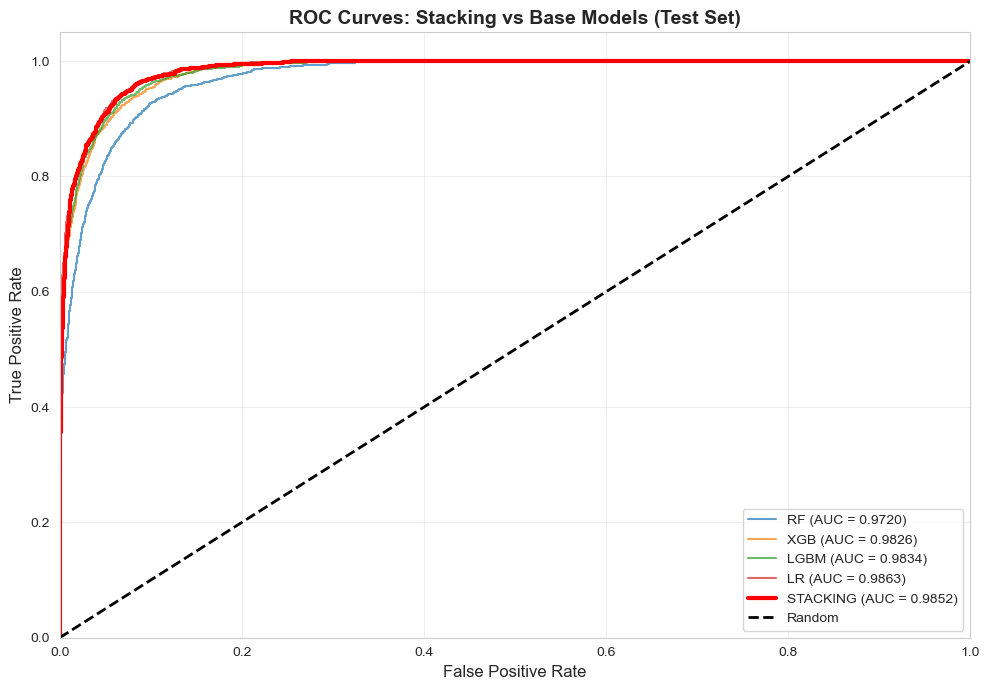

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\roc_curves_comparison.png


In [14]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 7))

# Plot base models
for name, results in base_results.items():
    test_proba_base = results['model'].predict_proba(X_test_prep)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, test_proba_base)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, alpha=0.7, label=f'{name.upper()} (AUC = {roc_auc:.4f})')

# Plot stacking ensemble
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_test_proba)
roc_auc_stack = auc(fpr_stack, tpr_stack)
plt.plot(fpr_stack, tpr_stack, lw=3, color='red', label=f'STACKING (AUC = {roc_auc_stack:.4f})')

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Stacking vs Base Models (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'roc_curves_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {os.path.join(OUTPUTS_DIR, 'roc_curves_comparison.png')}")

## 13. Visualization: Model Performance Comparison

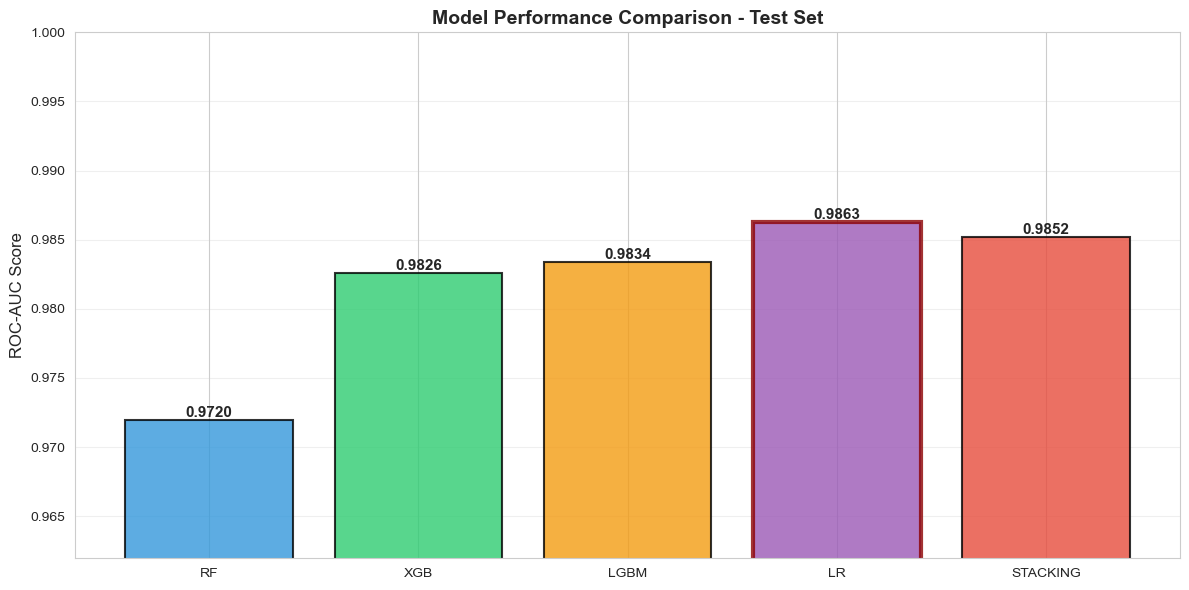

Saved: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\models_performance_comparison.png


In [15]:
# Create performance comparison bar chart
models_names = [name.upper() for name in base_results.keys()] + ['STACKING']

# Get test ROC-AUC for each base model
test_roc_scores = []
for name, results in base_results.items():
    test_proba_base = results['model'].predict_proba(X_test_prep)[:, 1]
    test_roc_scores.append(roc_auc_score(y_test, test_proba_base))
test_roc_scores.append(test_roc)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
bars = ax.bar(models_names, test_roc_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Highlight the best model
best_idx = np.argmax(test_roc_scores)
bars[best_idx].set_edgecolor('darkred')
bars[best_idx].set_linewidth(3)

ax.set_ylabel('ROC-AUC Score', fontsize=12)
ax.set_title('Model Performance Comparison - Test Set', fontsize=14, fontweight='bold')
ax.set_ylim(min(test_roc_scores) - 0.01, 1.0)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, test_roc_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUTS_DIR, 'models_performance_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: {os.path.join(OUTPUTS_DIR, 'models_performance_comparison.png')}")

## 14. Save Stacking Model and Results

In [16]:
# Save final stacking model
model_path = os.path.join(OUTPUTS_DIR, 'stacking_model.pkl')
joblib.dump(final_stacking_model, model_path)
print(f"Saved stacking model: {model_path}")

# Save evaluation results
ensemble_results = {
    'stacking_ensemble': {
        'test': {
            'roc_auc': float(test_roc),
            'pr_auc': float(test_pr),
            'f1': float(test_f1),
            'precision': float(test_precision),
            'recall': float(test_recall),
            'threshold': float(best_threshold),
            'confusion_matrix': test_cm.tolist(),
            'lift_at_top_20': {
                'lift': float(lift_value),
                'recall': float(lift_recall)
            }
        },
        'base_models': {
            name: {
                'val_roc_auc': float(results['val_roc_auc']),
                'val_pr_auc': float(results['val_pr_auc'])
            }
            for name, results in base_results.items()
        },
        'config': {
            'base_models_count': len(base_models),
            'meta_learner': meta_learner.__class__.__name__,
            'cv_folds': 5,
            'random_state': RANDOM_STATE
        }
    }
}

results_path = os.path.join(OUTPUTS_DIR, 'stacking_evaluation_summary.yaml')
with open(results_path, 'w') as f:
    yaml.safe_dump(ensemble_results, f)
print(f"Saved evaluation results: {results_path}")

print("\n✅ All artifacts saved successfully!")

Saved stacking model: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\stacking_model.pkl
Saved evaluation results: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\stacking_evaluation_summary.yaml

✅ All artifacts saved successfully!


## 15. Final Summary and Recommendations

In [17]:
print("="*70)
print("STACKING ENSEMBLE TRAINING - FINAL SUMMARY")
print("="*70)

print("\n📊 MODEL ARCHITECTURE:")
print(f"  Base Models (Level 0): {len(base_models)}")
for name, _ in base_models:
    print(f"    - {name.upper()}")
print(f"  Meta-Learner (Level 1): {meta_learner.__class__.__name__}")
print(f"  Cross-Validation: 5-fold")

print("\n🎯 TEST SET PERFORMANCE:")
print(f"  ROC-AUC:   {test_roc:.4f}")
print(f"  PR-AUC:    {test_pr:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

print("\n💼 BUSINESS IMPACT:")
print(f"  Lift @ Top 20%: {lift_value:.2f}x")
print(f"  → Targeting top 20% captures {lift_recall:.1%} of churners")
print(f"  → {lift_value:.2f}x more effective than random targeting")

print("\n📁 SAVED ARTIFACTS:")
print(f"  - Model: {model_path}")
print(f"  - Results: {results_path}")
print(f"  - Visualizations: {OUTPUTS_DIR}/*.png")

print("\n" + "="*70)

if os.path.exists(baseline_eval_path):
    improvement = test_roc - baseline_test['roc_auc']
    if improvement > 0.001:
        print("✅ RECOMMENDATION: Use stacking ensemble for production")
        print(f"   → Improvement: +{improvement*100:.2f}% ROC-AUC over baseline")
    else:
        print("💡 RECOMMENDATION: Consider using baseline model for production")
        print("   → Simpler, faster inference with comparable performance")
        print("   → Stacking adds complexity without significant gain")
else:
    print("📝 Run baseline training notebook to enable comparison")

print("\n" + "="*70)
print("🎉 Stacking ensemble training complete!")
print("="*70)

STACKING ENSEMBLE TRAINING - FINAL SUMMARY

📊 MODEL ARCHITECTURE:
  Base Models (Level 0): 4
    - RF
    - XGB
    - LGBM
    - LR
  Meta-Learner (Level 1): LogisticRegression
  Cross-Validation: 5-fold

🎯 TEST SET PERFORMANCE:
  ROC-AUC:   0.9852
  PR-AUC:    0.9576
  F1-Score:  0.8796
  Precision: 0.8867
  Recall:    0.8725

💼 BUSINESS IMPACT:
  Lift @ Top 20%: 3.82x
  → Targeting top 20% captures 76.3% of churners
  → 3.82x more effective than random targeting

📁 SAVED ARTIFACTS:
  - Model: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\stacking_model.pkl
  - Results: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble\stacking_evaluation_summary.yaml
  - Visualizations: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\outputs\ensemble/*.png

✅ RECOMMENDATION: Use stacking ensemble for production
   → Improvement: +0.11% ROC-AUC over baseline

🎉 Stacking 